In [15]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_DIR = r'C:\Users\Ashutosh\Desktop\mini522\img2'  #image folder path
train_csv_path = r'C:\Users\Ashutosh\Desktop\mini522\train.csv'  #CSV path

# Load the file
data_df = pd.read_csv(train_csv_path)

# Convert 'diagnosis' column to binary (0 for no retinopathy, 1 for retinopathy)
data_df['diagnosis'] = data_df['diagnosis'].apply(lambda x: 1 if x > 0 else 0)

# Function to load, preprocess, and apply Gaussian blur to images
def load_images(df, images_dir, img_size=(128, 128),kernal_size=(5,5)):
    images = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading Images"):    #for visvalization of loading data
        img_id = row['id_code']
        label = row['diagnosis']
        img_path = os.path.join(images_dir, f"{img_id}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = cv2.GaussianBlur(img, kernal_size, 0)  # Applying  Gaussian blur
            images.append(img)
            labels.append(label)
    images = np.array(images) / 255.0  # Normalizing the images
    labels = np.array(labels)
    return images, labels


# Splitting the data into training, validation, and test sets
train_df, test_df = train_test_split(data_df, test_size=0.2, stratify=data_df['diagnosis'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['diagnosis'], random_state=42)

# Load and preprocess the images
X_train, y_train = load_images(train_df, IMG_DIR)
X_val, y_val = load_images(val_df, IMG_DIR)
X_test, y_test = load_images(test_df, IMG_DIR)

Epoch 1/20
92/92 [==============================] - 45s 479ms/step - loss: 3.0978 - accuracy: 0.7067 - val_loss: 0.9661 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 2/20
92/92 [==============================] - 44s 475ms/step - loss: 0.6613 - accuracy: 0.7378 - val_loss: 0.8309 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 3/20
92/92 [==============================] - 43s 468ms/step - loss: 0.4838 - accuracy: 0.7975 - val_loss: 1.1583 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 4/20
92/92 [==============================] - 43s 471ms/step - loss: 0.4406 - accuracy: 0.8334 - val_loss: 0.5502 - val_accuracy: 0.6749 - lr: 0.0010
Epoch 5/20
92/92 [==============================] - 44s 477ms/step - loss: 0.4691 - accuracy: 0.8262 - val_loss: 0.4447 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 6/20
92/92 [==============================] - 43s 467ms/step - loss: 0.4162 - accuracy: 0.8508 - val_loss: 0.5725 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 7/20
92/92 [==============================] - 43s 466ms/st

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


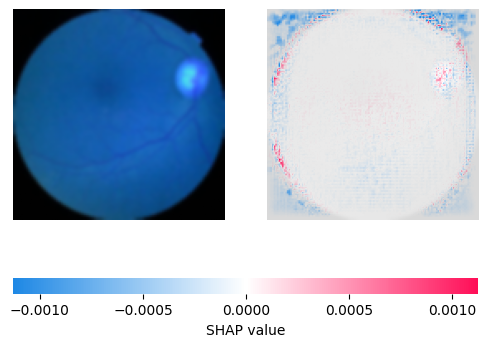

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


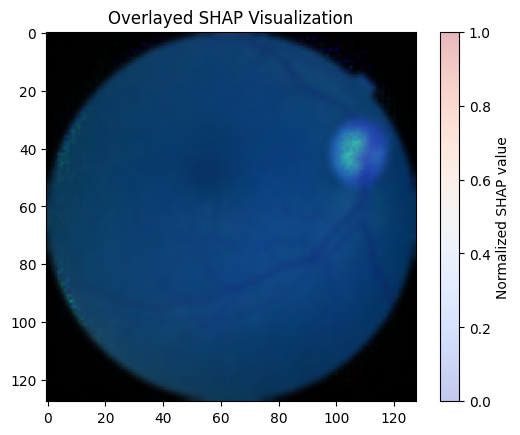

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Define the model
model = Sequential([
    Input(shape=(128, 128, 3)),  # Adjust the input shape for your dataset
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Augmented data
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model in the recommended Keras format
model.save('my_model.keras')

# Perform SHAP analysis
# Select a subset of the training data as the background dataset for SHAP
background = X_train[:100]
test_image = X_test[0:1]  # Example test image

# Create a SHAP explainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(test_image)

# Visualize SHAP values
shap.image_plot(shap_values, test_image)

# Visualize normalized SHAP values with overlay
shap_values_normalized = shap_values[0][0] / np.max(np.abs(shap_values[0][0]))
plt.imshow(test_image[0])  # Show the original image
plt.imshow(shap_values_normalized, cmap='coolwarm', alpha=0.3)  # SHAP overlay
plt.colorbar(label='Normalized SHAP value')
plt.title("Overlayed SHAP Visualization")
plt.show()


Predicted Class: 0 (Confidence: 0.10)


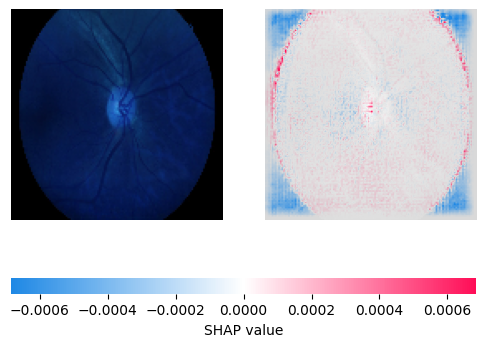

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


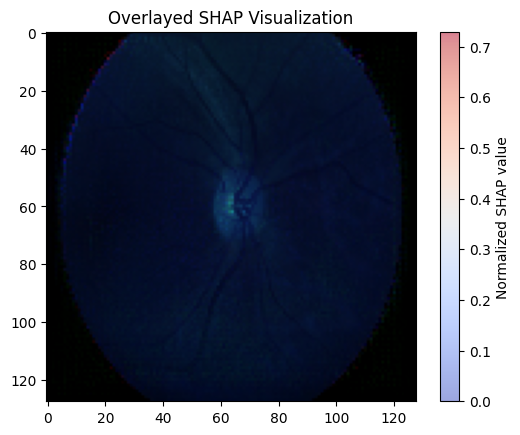

In [13]:
import os
import tensorflow as tf
import numpy as np
import cv2
import shap
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('my_model.keras')

# Function to preprocess a single image
def preprocess_image(img_path, img_size=(128, 128)):
    """
    Load and preprocess a single image for prediction.
    Args:
        img_path (str): Path to the image.
        img_size (tuple): Desired image size (height, width).
    Returns:
        np.ndarray: Preprocessed image.
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)  # Resize image
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict and analyze a single image
def predict_and_analyze(img_path, model):
    """
    Predicts the class of an image and performs SHAP analysis.
    Args:
        img_path (str): Path to the image.
        model (tensorflow.keras.Model): Trained model.
    """
    # Preprocess the image
    preprocessed_img = preprocess_image(img_path)
    
    # Predict the class
    prediction = model.predict(preprocessed_img)
    predicted_class = 1 if prediction[0][0] > 0.5 else 0
    print(f"Predicted Class: {predicted_class} (Confidence: {prediction[0][0]:.2f})")
    
    # SHAP Analysis
    # Select a subset of the training data as background for SHAP
    background = X_train[:100]
    
    # Create a SHAP explainer
    explainer = shap.GradientExplainer(model, background)
    
    # Compute SHAP values for the given image
    shap_values = explainer.shap_values(preprocessed_img)
    
    # Visualize SHAP values
    shap.image_plot(shap_values, preprocessed_img)

    # Overlay SHAP values on the image
    shap_values_normalized = shap_values[0][0] / np.max(np.abs(shap_values[0][0]))
    plt.imshow(preprocessed_img[0])  # Show the original image
    plt.imshow(shap_values_normalized, cmap='coolwarm', alpha=.5)  # SHAP overlay
    plt.colorbar(label='Normalized SHAP value')
    plt.title("Overlayed SHAP Visualization")
    plt.show()

# Path to the image you want to predict
image_path = r"C:\Users\Ashutosh\Desktop\mini522\img\0fbbd665431f.png"  # Replace with your image path

# Predict and perform SHAP analysis
predict_and_analyze(image_path, model)


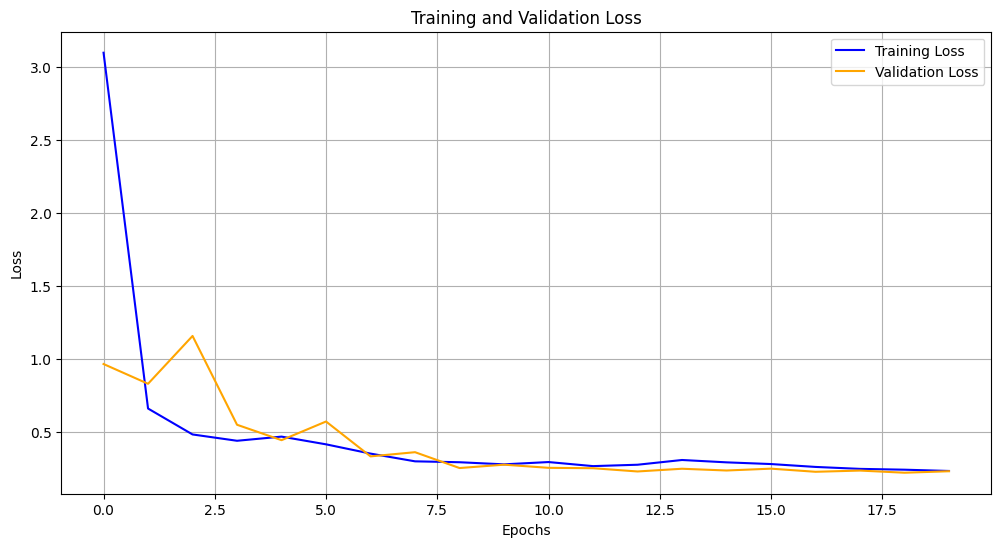

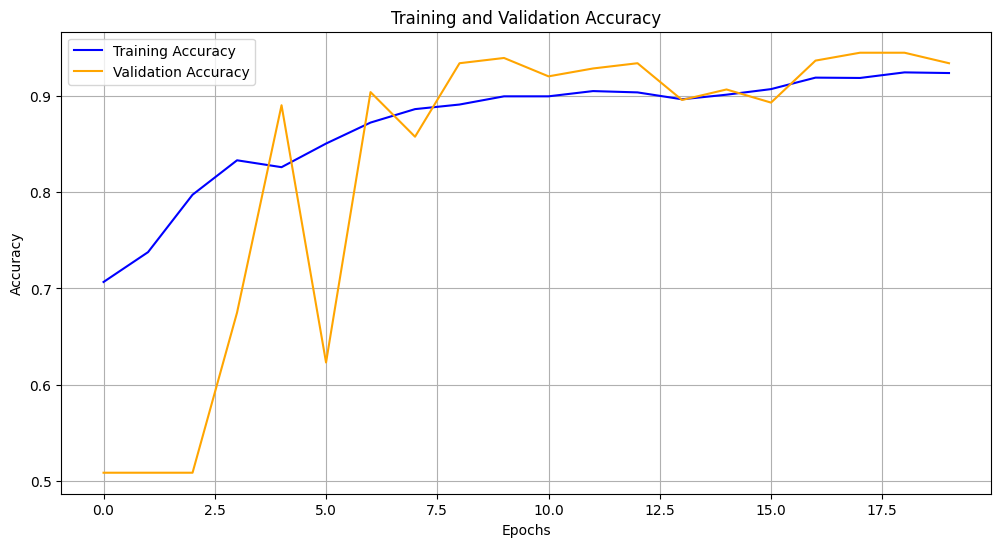

In [14]:
import matplotlib.pyplot as plt

# Extract data from the training history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
